# This notebook computes "numerical J's": 
# the sensitivity functions of retracked parameters (Hs,z) to a localizd wave height perturbation defined by (a,b) 

In [1]:
## Import packages
import numpy as np

from altimetry_waveforms_functions import *
import matplotlib.pyplot as plt


In [2]:
clight = 299792458
Rearth = 6378.1363*(10**3)

# --- satellite parameters ----------------------------
v_sat = 7*1e3 # satellite velocity in m/s
Altis = np.array([519*1e3, 781*1e3, 800*1e3, 891*1e3, 1340*1e3])
namesAltis = ['CFOSAT', 'SARAL', 'ENVISAT', 'SWOT', 'Jason3']
BW = np.array([(400*1e6),(500*1e6),(320*1e6),(320*1e6),(320*1e6)])
BX = np.array([(320*1e6),(500*1e6),(320*1e6),(320*1e6),(320*1e6)])
theta3dBs=np.array([(1.6),(0.61),(1.28),(1.28),(1.28)])*np.pi/180.

ialti = 0  # choice is SWIM on CFOSAT 

theta3dB=theta3dBs[ialti]
alti_sat = Altis[ialti]
bandwidth = BW[ialti]       # bandwidth in Hz giving the time resolution of waveform (note that CFOSAT/SWIM is oversampled to a 400 MHz band)
bandx     = BX[ialti]       # real bandwidth in Hz 
nameSat = namesAltis[ialti]
tau=1E9/bandwidth           # time interval in nanoseconds
stonano=1000000000

dr = clight * 1/(2*bandwidth)


Hs=10.
sigs=0.25*Hs*2/clight*stonano               # sigma_s
Earth_sphericity_coef=(1+alti_sat/Rearth)   # 1+alti_sat/Rearth, 1 -> flat Earth 
nominal_tracking_gate=64
range_offset = nominal_tracking_gate*dr  # number of meters above nadir sea level included in waveform

nr=128
ranges = np.arange(0,(nr-1)*dr,dr)   


tax=1E9/bandx     # resolution in nanoseconds

rtot=(2./clight)*stonano  #Converts range to time
times=ranges*rtot
nr2=int(nr/2)
t0=tau*(nr2-1)
PTR=(np.sinc(np.pi*(times-t0)/tax))**2

s=sum(PTR)
PTR=PTR.T/s
noise=1E-3
PTM='True'
#PTR=[1]
timeshift=tau*nominal_tracking_gate
    

## Loops on b to compute J

In [3]:
db=0.01;nb=int(2.01/db)+1
barray=np.arange(start=0, stop=2.01, step=db)
print(np.shape(barray),nb)
waveforms=np.zeros([1,nb,nr-1])
waveforms0=np.zeros([1,nb,nr-1])
waveforms2=np.zeros([1,nb,nr-1])
waveforms3=np.zeros([1,nb,nr-1])
waveforms4=np.zeros([1,nb,nr-1])

# Defines the amplitude of the regional wave height anomaly
a=0.1
a2=-0.02



min_gate_rat=0.06


# loops on b (off-nadir distance where anomaly is located) 
for ib in range(nb):
    b=barray[ib]
    wf_fit=wf_eval(ranges,np.array((0,Hs,1.,a,b)),clight,'wf_erf4D',PTR_model='True',PTR=PTR,noise=noise,alti_sat=alti_sat,\
                            tau=tau,nominal_tracking_gate=nominal_tracking_gate,mispointing=0.,theta3dB=theta3dB,Earth_sphericity_coef=1)
    wf_fit0=wf_eval(ranges,np.array((0,Hs,1.,a,b)),clight,'wf_erf4D',PTR_model='True',PTR=([1.]),noise=noise,alti_sat=alti_sat,\
                            tau=tau,nominal_tracking_gate=nominal_tracking_gate,mispointing=0.,theta3dB=theta3dB,Earth_sphericity_coef=1)
    wf_fit2=wf_eval(ranges,np.array((0,Hs,1.,a,b)),clight,'wf_bro4D',PTR_model='True',PTR=PTR,noise=noise,alti_sat=alti_sat,\
                            tau=tau,nominal_tracking_gate=nominal_tracking_gate,mispointing=0.,theta3dB=theta3dB,Earth_sphericity_coef=1)
    wf_fit3=wf_eval(ranges,np.array((0,Hs,1.,a2,b)),clight,'wf_bro4D',PTR_model='True',PTR=PTR,noise=noise,alti_sat=alti_sat,\
                            tau=tau,nominal_tracking_gate=nominal_tracking_gate,mispointing=0.,theta3dB=theta3dB,Earth_sphericity_coef=1)
    wf_fit4=wf_eval(ranges,np.array((0,Hs,1.,a,b)),clight,'wf_bro4D',PTR_model='True',PTR=PTR,noise=noise,alti_sat=alti_sat,\
                            tau=tau,nominal_tracking_gate=nominal_tracking_gate,mispointing=0.,theta3dB=theta3dB,Earth_sphericity_coef=Earth_sphericity_coef)
    waveforms[0,ib,:]=wf_fit[:]
    waveforms0[0,ib,:]=wf_fit0[:]
    waveforms2[0,ib,:]=wf_fit2[:]
    waveforms3[0,ib,:]=wf_fit3[:]
    waveforms4[0,ib,:]=wf_fit4[:]

m1=45 # this is the startgate for retracking
max_range_fit=127 # this is stopgate in WHALES

print('Maximum waveform index used for retracking:',max_range_fit)

# Retracks all the waveforms with different retracking options     
Hs_1,ze_1,Pu,dar,R0r,di_1=retrack_waveforms(waveforms,ranges,max_range_fit,clight,tau=tau,\
                        min_method='Nelder-Mead',PTR_model='True',PTR=PTR, wf_model='wf_erf2D',costfun='LS',mispointing=[0.],\
                        theta3dB=theta3dB,alti_sat=alti_sat,nominal_tracking_gate=nominal_tracking_gate,min_range_fit=m1,min_gate_rat=0.)

Hs_2,ze_2,Pu2,dar2,R0r2,di_2=retrack_waveforms(waveforms0,ranges,max_range_fit,clight,tau=tau,\
                        min_method='Nelder-Mead',PTR_model='True',PTR=([1.]), wf_model='wf_erf2D',costfun='LS',mispointing=[0.],\
                        theta3dB=theta3dB,alti_sat=alti_sat,nominal_tracking_gate=nominal_tracking_gate,min_range_fit=m1,min_gate_rat=0.)

Hs_3,ze_3,Pu,dar,R0r,di_3=retrack_waveforms(waveforms2,ranges,max_range_fit,clight,tau=tau,\
                        min_method='Nelder-Mead',PTR_model='True',PTR=PTR, wf_model='wf_brown',costfun='ML',mispointing=[0.],\
                        theta3dB=theta3dB,alti_sat=alti_sat,nominal_tracking_gate=nominal_tracking_gate,min_range_fit=m1,min_gate_rat=0.)

Hs_4,ze_4,Pu,dar,R0r,di_1=retrack_waveforms(waveforms2,ranges,max_range_fit,clight,tau=tau,\
                        min_method='Nelder-Mead',PTR_model='True',PTR=PTR, wf_model='wf_brown',costfun='LS',mispointing=[0.],\
                        theta3dB=theta3dB,alti_sat=alti_sat,nominal_tracking_gate=nominal_tracking_gate,min_range_fit=m1,min_gate_rat=0.)

Hs_5,ze_5,Pu,dar5,R0r5,di_5=retrack_waveforms(waveforms2,ranges,max_range_fit,clight,tau=tau,\
                        min_method='Nelder-Mead',PTR_model='True',PTR=PTR, wf_model='wf_brown',costfun='ML',mispointing=[0.],\
                        theta3dB=theta3dB,alti_sat=alti_sat,nominal_tracking_gate=nominal_tracking_gate,min_range_fit=m1,min_gate_rat=min_gate_rat)

Hs_6,ze_6,Pu_6,dar6,R0r6,di_5=retrack_waveforms(waveforms3,ranges,max_range_fit,clight,tau=tau,\
                        min_method='Nelder-Mead',PTR_model='True',PTR=PTR, wf_model='wf_brown',costfun='ML',mispointing=[0.],\
                        theta3dB=theta3dB,alti_sat=alti_sat,nominal_tracking_gate=nominal_tracking_gate,min_range_fit=m1,min_gate_rat=min_gate_rat)

Hs_7,ze_7,Pu_7,dar6,R0r6,di_5=retrack_waveforms(waveforms4,ranges,max_range_fit,clight,tau=tau,\
                        min_method='Nelder-Mead',PTR_model='True',PTR=PTR, wf_model='wf_brown',costfun='LS',mispointing=[0.],\
                        theta3dB=theta3dB,alti_sat=alti_sat,nominal_tracking_gate=nominal_tracking_gate,min_range_fit=m1,min_gate_rat=0.,Earth_sphericity_coeff=Earth_sphericity_coef)



(201,) 201
Maximum waveform index used for retracking: 127
size of waveforms array: 1 201 127 alti_sat: 519000.0
Estimated noise level: 0.00100944942762652 160.0
Retracking waveforms 0  out of  1  ------------ 
size of waveforms array: 1 201 127 alti_sat: 519000.0
Estimated noise level: 0.0010000000000000057 160.0
Retracking waveforms 0  out of  1  ------------ 
size of waveforms array: 1 201 127 alti_sat: 519000.0
Estimated noise level: 0.001008775866984475 160.0
Retracking waveforms 0  out of  1  ------------ 
size of waveforms array: 1 201 127 alti_sat: 519000.0
Estimated noise level: 0.001008775866984475 160.0
Retracking waveforms 0  out of  1  ------------ 
size of waveforms array: 1 201 127 alti_sat: 519000.0
Estimated noise level: 0.001008775866984475 160.0
Retracking waveforms 0  out of  1  ------------ 
size of waveforms array: 1 201 127 alti_sat: 519000.0
Estimated noise level: 0.0010087622975053973 160.0
Retracking waveforms 0  out of  1  ------------ 
size of waveforms arra

mean JH: 1.1749820037133305 0.49990161021813706 0.4542721610083065 0.5554884191607006 1.7345207428380713
mean Jz: 0.004975331405362752 0.00346653262441611 -0.055446818012653346


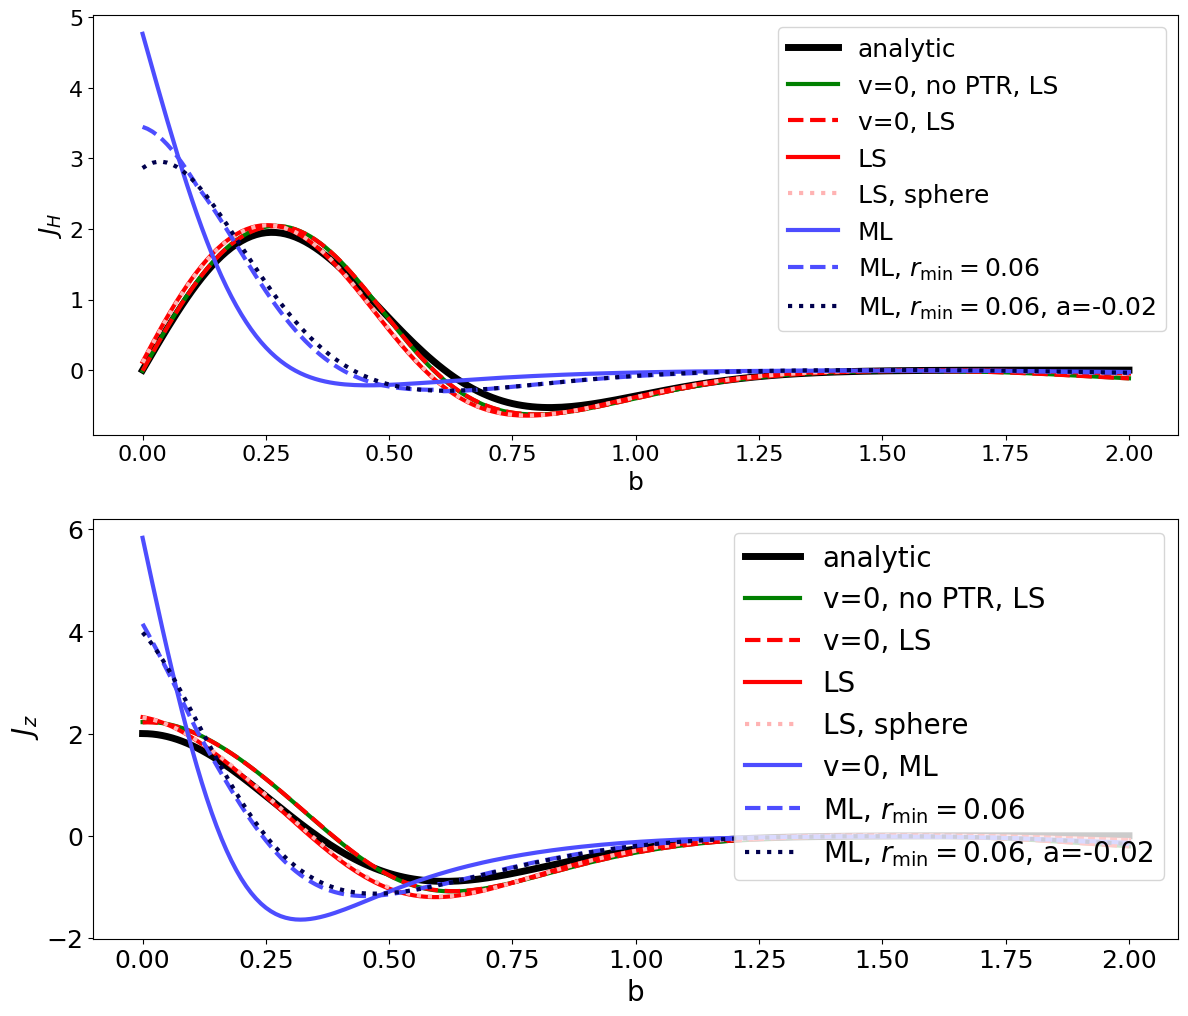

In [4]:
fig,axs=plt.subplots(2,1,figsize=(14,12))
ax=axs[0]
w1=5
w2=3
line1=ax.plot(barray,2*barray*(6- 16*barray**2)*np.exp(-4*barray**2),color='k',lw=w1,label='analytic')
line1=ax.plot(barray,2*(Hs_2.T-Hs)/(a*Hs),color='g',lw=w2,label='v=0, no PTR, LS')
line1=ax.plot(barray,2*(Hs_1.T-Hs)/(a*Hs),color='r',linestyle='dashed',lw=w2,label='v=0, LS')
line1=ax.plot(barray,2*(Hs_4.T-Hs)/(a*Hs),color='r',lw=w2,label='LS')
line1=ax.plot(barray,2*(Hs_7.T-Hs)/(a*Hs),color=[1, 0.7, 0.7],lw=w2,linestyle='dotted',label='LS, sphere')
line1=ax.plot(barray,2*(Hs_3.T-Hs)/(a*Hs),color=[0.3,0.3,1],lw=w2,label='ML')
line1=ax.plot(barray,2*(Hs_5.T-Hs)/(a*Hs),color=[0.3,0.3,1],lw=w2,linestyle='dashed',label='ML, $r_{\mathrm{min}}=0.06$')
line1=ax.plot(barray,2*(Hs_6.T-Hs)/(a2*Hs),color=[0,0,0.3],lw=w2,linestyle='dotted',label='ML, $r_{\mathrm{min}}=0.06$, a=-0.02')
#line2=ax.plot(ranges[min_range_fit:max_range_fit],wf_fit2[min_range_fit:max_range_fit]-wf_fit0[min_range_fit:max_range_fit],color='b',label='erf2D')
ax.set_xlabel('b', fontsize=18)
ax.set_ylabel(r'$J_H$ ', fontsize=18)
leg = ax.legend(loc='upper right', fontsize=18)
ax.tick_params(axis='both', labelsize=16)
ax=axs[1]
line1=ax.plot(barray,(2- 16*barray**2)*np.exp(-4*barray**2),lw=w1,color='k',label='analytic')
line1=ax.plot(barray,16*ze_2.T/(a*Hs),color='g',lw=w2,label='v=0, no PTR, LS')
line1=ax.plot(barray,16*ze_1.T/(a*Hs),color='r',lw=w2,linestyle='dashed',label='v=0, LS')
line1=ax.plot(barray,16*ze_4.T/(a*Hs),color='r',lw=w2,label='LS')
line1=ax.plot(barray,16*ze_7.T/(a*Hs),color=[1, 0.7, 0.7],lw=w2,linestyle='dotted',label='LS, sphere')
line1=ax.plot(barray,16*ze_3.T/(a*Hs),color=[0.3,0.3,1],lw=w2,label='v=0, ML')
line1=ax.plot(barray,16*ze_5.T/(a*Hs),color=[0.3,0.3,1],lw=w2,linestyle='dashed',label='ML, $r_{\mathrm{min}}=0.06$')
line1=ax.plot(barray,16*ze_6.T/(a2*Hs),color=[0,0,0.3],lw=w2,linestyle='dotted',label='ML, $r_{\mathrm{min}}=0.06$, a=-0.02')
#line2=ax.plot(ranges[min_range_fit:max_range_fit],wf_fit2[min_range_fit:max_range_fit]-wf_fit0[min_range_fit:max_range_fit],color='b',label='erf2D')
ax.set_xlabel('b', fontsize=20)
ax.set_ylabel(r' $J_z$', fontsize=20)
leg = ax.legend(loc='upper right', fontsize=20)
ax.tick_params(axis='both', labelsize=18)
fig.savefig('Fig5_Js_for_a_0p1_start45_lownoise_Hs10_rat06.pdf')

meanJHa=np.sum(2*barray*(6- 16*barray**2)*np.exp(-4*barray**2))*db
meanJHa2=np.sum((2*barray*(6- 16*barray**2)*np.exp(-4*barray**2))**2)*db
meanJH2=np.sum(2*(Hs_2.T-Hs)/(a*Hs))*db
meanJH52=np.sum((2*(Hs_5.T-Hs)/(a*Hs))**2)*db
meanJH5=np.sum(2*(Hs_5.T-Hs)/(a*Hs))*db

meanJza=np.mean((2- 16*barray**2)*np.exp(-4*barray**2))
meanJz2=np.mean(16*ze_2.T/(a*Hs))
meanJz5=np.mean(16*ze_5.T/(a*Hs))
print('mean JH:',meanJHa2,meanJHa,meanJH2,meanJH5,meanJH52)
print('mean Jz:',meanJza,meanJz2,meanJz5)